# YoloV3 Model Experimentation 1

The following implements a simple object detection model using ResNet-50 as a backbone.

In [1]:
import IPython.core.display as di
from IPython.display import Markdown as md

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )
    
def md_cat(file_path):
    with open(file_path) as file:
        return md(f"```python\n{file.read()}\n```")

toggle_code()

Toggle code

In [2]:
import json
import os
import sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as torchv
from matplotlib import patches
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
data_path = "../data"
sys.path.append(data_path)

In [4]:
from augment_data import augment_data, originals, boxes
from LossAccumulator import LossAccumulator
from Parameters import Parameters
from Dataset import Dataset

## Parameters

In [5]:
params = Parameters("params_v1.yml")

In [6]:
assert params.use_gpu

In [7]:
log = logging.getLogger('Model')
hdlr = logging.FileHandler(params.log_file)
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
log.addHandler(hdlr)
log.setLevel(logging.INFO)

## Load Data

See the [data augmentation notebook](https://github.com/antoniojkim/WheresWaldo-YoloV3/blob/master/data/data.ipynb) for more details on how the data was curated and augmented.

In [8]:
md_cat("Dataset.py")

```python

import numpy as np
import torch
import torchvision as torchv
from PIL import Image

class Dataset:
    
    def __init__(self, data):
        self.data = data        
        self.to_tensor = torchv.transforms.ToTensor()
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        dims = self.data[index]["crop"]
        x, y, w, h = dims['x'], dims['y'], dims['w'], dims['h']
        image = self.data[index]["image"][y:y+h, x:x+w]    
        if dims["hflip"]:
            image = torchv.transforms.functional.hflip(Image.fromarray(image))

        train = self.to_tensor(image)
        
        if "box" in self.data[index]:
            box = self.data[index]['box']
            x, y, w, h = box['x'], box['y'], box['w'], box['h']
            label = torch.from_numpy(np.log1p((x + w // 2, y + h // 2, w, h, 1)))
        else:
            label = torch.from_numpy(np.log1p((0, 0, 0, 0, 0)))
        
        return train, label

```

In [9]:
np.random.seed(20200422)
data = augment_data(augment_times=100)

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    Dataset(data),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

## Define Model

In [11]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [12]:
resnet = torchv.models.resnet50(pretrained=True)
resnet = to_device(resnet)

for param in resnet.parameters():
    param.requires_grad = False

In [13]:
class ModelV1(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
            
        self.fc1 = torch.nn.Linear(1000, 256)
        self.fc2 = torch.nn.Linear(256, 5)
        
    def forward(self, x):
        output = resnet(x)
        output = self.fc1(output)
        torch.nn.functional.relu(output, inplace=True)
        output = self.fc2(output)
        torch.nn.functional.relu(output, inplace=True)
        return output
    
    def __call__(self, x):
        return self.forward(x)
    
model = ModelV1()
model = to_device(model)

In [14]:
# load pretrained model if exists
if params.pretrained_model_path is not None and os.path.isfile(params.pretrained_model_path):
    print('loading model from %s ...' % params.pretrained_model_path)
    model.load_state_dict(torch.load(params.pretrained_model_path), strict=False)

loading model from ./.checkpoints/latest_model_v1.pt ...


In [15]:
optimizer = torch.optim.SGD(model.parameters(), params.learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()

criterion = torch.nn.MSELoss()

In [16]:
for epoch in range(params.epoch_start, params.num_epochs):
    
    with tqdm(total=len(train_dataloader), position=0, leave=False) as progress, \
        LossAccumulator(optimizer, 4) as lossAccumulator:
        
        progress.set_description('epoch %d, lr %f' % (epoch, params.learning_rate))
        
        for i, (images, labels) in enumerate(train_dataloader):
            
            images = to_device(images)
            labels = to_device(labels)

            output = model.forward(images)
            loss = criterion(output.double(), labels.double())
            
            info = f"Epoch {epoch}, lr {params.learning_rate}, i {i}, loss {loss.item()}"
            if np.isnan(loss.item()):
                log.warning(info)
                break
            else:
                log.info(info)
            
            loss.backward()

            progress.set_postfix(loss='%.6f' % loss.item())
            progress.update()

            next(lossAccumulator)
            
        if epoch % params.checkpoint_step == 0:
            if not os.path.isdir(params.save_model_path):
                os.mkdir(params.save_model_path)

            torch.save(model.state_dict(),
                       os.path.join(params.save_model_path, 'latest_model_v1.pt'))

torch.cuda.empty_cache()

In [17]:
torch.save(model.state_dict(),
           os.path.join(params.save_model_path, 'latest_model_v1.pt'))

## Validation

The loss metric was not very good and as such, I don't expect the model to be able to correctly guess the location of Waldo.

In [18]:
class TestDataset:
    def __init__(self):
        self.data = [(originals[key], boxes[key]) for key in originals.keys()]
        self.to_tensor = torchv.transforms.ToTensor()
    
    def __getitem__(self, index):
        test, label = self.data[index]
        test = self.to_tensor(test)
        label = torch.from_numpy(np.array(label))
        return test, label
    
    def __len__(self):
        return len(self.data)

In [19]:
test_dataloader = torch.utils.data.DataLoader(
    TestDataset(),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

In [20]:
with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = to_device(images)
        output = model.forward(images)
        break

In [21]:
waldo_map = images.cpu().detach().numpy()
waldo_map = np.moveaxis(np.squeeze(waldo_map, axis=0), 0, -1)

In [22]:
prediction_box = np.expm1(output.cpu().detach().numpy())
label_box = labels.detach().numpy()

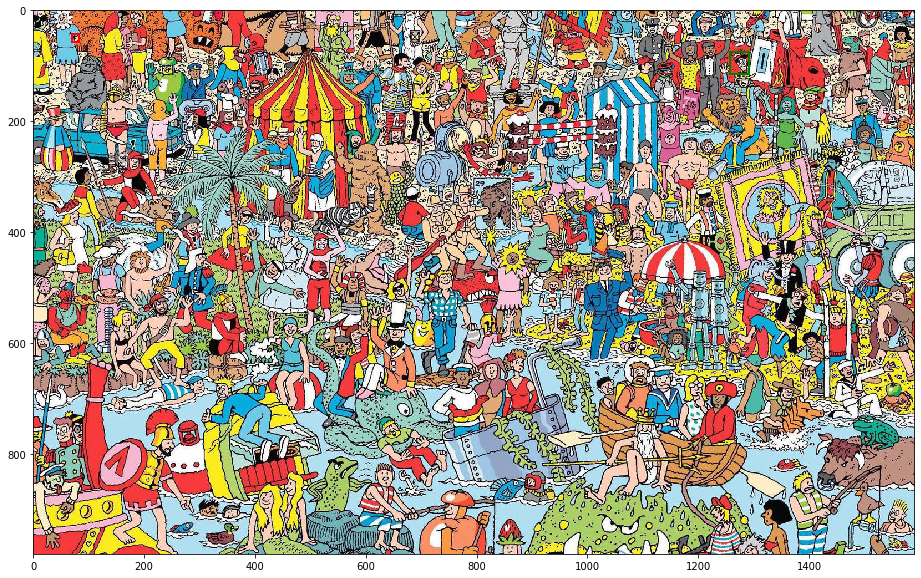

In [28]:
fig, ax = plt.subplots(1, figsize=(18, 10))
ax.imshow(waldo_map)
x, y, w, h, c = prediction_box[0]
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
x, y, w, h = label_box[0]
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none'))
plt.show()

Although it may be hard to see in the above image, there is a red box (top left) which represents the prediction made by the model for where Waldo is on the map as well as a green box (top right) which represents Waldo's true location.

It is clear that the model is not performing all that well. However, this was expected given the simplistic nature of this initial attempt.

We now move onto the next iteration of the model.